**Autor: Mariana Chaves**
 
**Date: August 2022**

In this notebook we train different deep models to classify movie characters according to their gender based on their dialogues. 
That is, each sample contains all utterances on the character.

We experiment with the following architectures and vary their hyperparameters: 

* Embedding + GlobalMaxPooling + Dense layer + Dense layer + softmax/sigmoid   
* Embedding + LSTM + Dense layer + Dense layer + softmax/sigmoid   
* Embedding + LSTM + Dense layer + softmax/sigmoid   
* Embedding + LSTM + GlobalMaxPooling + softmax/sigmoid   
* Embedding + Bidirectional LSTM + Dense layer + Dense layer + softmax/sigmoid   
* Embedding + Bidirectional LSTM + Dense layer + softmax/sigmoid 

This variations add up to 84 different models. These models are trained and evaluated using classic train, validation, test splitting. 

From the 84 models, the best 5 were selected to be trained again, this time using **leave-some-movies-out** cross-validation.


## Setup

In [25]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import myfunctions
import pandas as pd
import time
import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

c:\Users\Dell\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%cd ..

c:\Users\Dell\Documents\UCA DSAI\Internship 2\Code\text-models


In [4]:
# Path for saving results
path_to_models = 'results/models/'

In [5]:
# Path for saving images
# Make sure to change this to your own path!!!
path_of_saving_images = '//wsl$/Ubuntu-20.04/home/mchaves/internship2/final_report/internship_report/img/'

# Functions

In [36]:
def train_deepmodels(x_train, x_val, x_test, y_train, y_val, y_test, model_info, path_to_models, epochs, model_name_suffix = '', save_results_to_pickle = True, return_results = False, verbose = 1):

    '''
    Trains different deep models.

    It creates the model with a particular architecture, size of layers and others, following the characteristics specified in model_info.  

    Inputs: 
        x_train, x_val, x_test: text lists of each dataset (train, validation test)
        y_train, y_val, y_test: target variable lists of each dataset (it is a one dimensional array)
        model_info: a dictionary specifying architecture and other caracteristics of the model. (notice that this is very specific for this experiments, see examples in the model_combinations variable below)
        path_to_models: path to directory to save the model
        epochs: number of epochs
        model_name_suffix: text to add to the name of the model. By default it doesn't add anything.
        save_results_to_pickle: If true, saves de results to a pickle file
        return_results: If true, returns the results
        verbose: verbosity of the training and evaluation proceses 
    '''

    # --------------------
    # Model name
    # --------------------
    model_name = model_info['model_name']

    # --------------------------
    # Data preparation
    # --------------------------

    # Test data by category
    x_test_1 = x_test[y_test == 1] 
    x_test_0 = x_test[y_test == 0]
    y_test_1 = y_test[y_test == 1] 
    y_test_0 = y_test[y_test == 0]

    # --------------------
    # Define output layer, loss and shape of target variable
    # --------------------
    # If Binary Cross-entropy is used, then the last layer uses sigmoid activation, and the target variable is a binary vector 
    # If Categorical Cross-entropy is used, then the last layer uses softmax activation, and the target variable is one-hot encoded 
    if model_info['last_layer_activation'] == 'sigmoid':
        output_layer = tf.keras.layers.Dense(1, activation = model_info['last_layer_activation'])
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        y_train_ = y_train
        y_val_ = y_val
        y_test_ = y_test
        y_test_0_ = y_test_0
        y_test_1_ = y_test_1
    elif model_info['last_layer_activation'] == 'softmax':
        output_layer = tf.keras.layers.Dense(2, activation = model_info['last_layer_activation'])
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
        # Target one-hot encoded. Ex: [[1,0],[0,1],[1,0]]
        y_train_ = np.array(pd.get_dummies(y_train))
        y_val_ = np.array(pd.get_dummies(y_val))
        y_test_ = np.array(pd.get_dummies(y_test))
        y_test_0_ = y_test_[y_test == 0]
        y_test_1_ = y_test_[y_test == 1]

    # --------------------
    # Architecture
    # --------------------
    if model_info['architecture'] == 'E+G+D+D':
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim = len(encoder.get_vocabulary()),
                output_dim = model_info['embedding_latent_space'],
                mask_zero = True), # Use masking to handle the variable sequence lengths
            tf.keras.layers.GlobalMaxPool1D(),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][0], activation = model_info['dense_layers_activation']),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][1], activation = model_info['dense_layers_activation']),
            output_layer
        ])

    if model_info['architecture'] == 'E+LSTM+D':
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim = len(encoder.get_vocabulary()),
                output_dim = model_info['embedding_latent_space'],
                mask_zero = True), # Use masking to handle the variable sequence lengths
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][0], activation = model_info['dense_layers_activation']),
            output_layer
        ])

    if model_info['architecture'] == 'E+LSTM+D+D':
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim = len(encoder.get_vocabulary()),
                output_dim = model_info['embedding_latent_space'],
                mask_zero = True), # Use masking to handle the variable sequence lengths
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][0], activation = model_info['dense_layers_activation']),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][1], activation = model_info['dense_layers_activation']),
            output_layer
        ])

    if model_info['architecture'] == 'E+LSTM+G':
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim=len(encoder.get_vocabulary()),
                output_dim = model_info['embedding_latent_space'],
                mask_zero=True), # Use masking to handle the variable sequence lengths
            tf.keras.layers.LSTM(64, return_sequences = True),
            tf.keras.layers.GlobalMaxPooling1D(),
            output_layer
        ])

    if model_info['architecture'] == 'E+BiLSTM+D':
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim = len(encoder.get_vocabulary()),
                output_dim = model_info['embedding_latent_space'],
                mask_zero = True), # Use masking to handle the variable sequence lengths
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][0], activation = model_info['dense_layers_activation']),
            output_layer
        ])

    if model_info['architecture'] == 'E+BiLSTM+D+D':
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim = len(encoder.get_vocabulary()),
                output_dim = model_info['embedding_latent_space'],
                mask_zero = True), # Use masking to handle the variable sequence lengths
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][0], activation = model_info['dense_layers_activation']),
            tf.keras.layers.Dense(model_info['dense_layers_sizes'][1], activation = model_info['dense_layers_activation']),
            output_layer
        ])

    # Callbacks
    mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + model_name + model_name_suffix + '.h5', monitor='val_loss', mode='min', save_best_only = True, verbose = 0)

    # Compile model
    model.compile(loss = loss,
                  optimizer = tf.keras.optimizers.Adam(1e-4),
                  metrics = ['accuracy'])

    # --------------------
    # Train
    # --------------------
    start_time = time.time()
    history = model.fit(x = x_train, y = y_train_, epochs = epochs, validation_data = (x_val, y_val_), callbacks = [mc], verbose = verbose)
    execution_time =  (time.time() - start_time) / 60

    # model.summary()

    # --------------------
    # Evaluate on test
    # --------------------
    # Load model
    saved_model = tf.keras.models.load_model(path_to_models + model_name + model_name_suffix + '.h5')
    # Evaluate in train and test set
    train_loss, train_accuracy = saved_model.evaluate(x_train, y_train_, verbose = verbose)
    test_loss, test_accuracy = saved_model.evaluate(x_test, y_test_, verbose = verbose)
    print('Test Accuracy:', test_accuracy)
    
    # Accuracy by label
    test_loss1, test_accuracy1 = saved_model.evaluate(x_test_1, y_test_1_, verbose = verbose)
    test_loss0, test_accuracy0 = saved_model.evaluate(x_test_0, y_test_0_, verbose = verbose)
    # Predictions in test
    if model_info['last_layer_activation'] == 'sigmoid':
      preds_test = np.round(model.predict(x_test),0).flatten().astype(int)
    elif model_info['last_layer_activation'] == 'softmax':
      preds_test = np.argmax(model.predict(x_test), axis = 1).astype(int)

    # --------------------------
    # Save results
    # --------------------------
    results = {'history_metrics': history.history, 
              'train_accuracy': train_accuracy, 
              'test_accuracy': test_accuracy, 
              'test_accuracy_1': test_accuracy1,
              'test_accuracy_0': test_accuracy0,
              'execution_time': execution_time,
              'predictions_on_test': preds_test,
              'text_test': x_test,
              'ground_truth': y_test,
              }
    if save_results_to_pickle: 
        pickle.dump(results, open( path_to_models + model_name + model_name_suffix + ".pickle", "wb" ))
    if return_results:
        return results

In [42]:
def leave_one_group_out_deepmodels(data, group_variable, text_variable, target_variable, model_info, path_to_models, epochs):
    '''
    Performs leave-one-group-out cross-validation on different deep models.
    The architecture of the model will be determined by the model_info parameter. 
    Leave-one-group-out is similar to leave-one-out with the difference that instead of leaving just one sample out each time, all samples belonging to a group are lefted out, and the work as test set.  
    The dataset should be provided as a pandas dataframe. 
    The dataset must contain a text variable, a binary target variable and a variable that indicates the groups for using leave-one-group-out. 

    Requiered arguments: 
        data: pandas dataframe. 
        group_variable: the name of the variable that contains the groups (for the leave-one-out)
        text_variable: the name of the variable that contains the text.
        target_variable: the name of the variable that contains the target variable (binary variable).
        model_info: a dictionary specifying architecture and other caracteristics of the model. (notice that this is very specific for this experiments, see examples in the model_combinations variable below)
        path_to_models: path to directory to save the model
        epochs: number of epochs
    '''

    # Groups for leave-one-group-out
    groups = np.unique(data[group_variable])

    # Empty dictionary to store results
    results = {'history_metrics': [], 'train_accuracy': [], 'test_accuracy': [], 'test_accuracy_1': [], 'test_accuracy_0': [], 'execution_time': [], 'predictions_on_test': [], 'text_test': [], 'ground_truth': []}

    # For each group
    for group in groups:
        #-----------------------------
        # Split train val test
        #-----------------------------

        train_data = data[data[group_variable] != group]
        test_data = data[data[group_variable] == group]

        x = train_data[text_variable]
        y = train_data[target_variable]
        x_test = test_data[text_variable]
        y_test = test_data[target_variable]
        x_train, x_val, y_train, y_val  = myfunctions.balanced_split_train_val_test(x, y, train_split = 0.8, val_split = 0, test_split = 0.2, random_seed = 32)

        # --------------------------
        # Train model
        # --------------------------
        results_group = train_deepmodels(x_train, x_val, x_test, y_train, y_val, y_test, 
                                         model_info = model_info,
                                         path_to_models = path_to_models,
                                         epochs = epochs,
                                         model_name_suffix = 'LOGO_temp',
                                         save_results_to_pickle = False, 
                                         return_results = True, 
                                         verbose = 0)
        # --------------------------
        # Save results
        # --------------------------
        results['history_metrics'].append(results_group['history_metrics'])
        results['train_accuracy'].append(results_group['train_accuracy'])
        results['test_accuracy'].append(results_group['test_accuracy'])
        results['test_accuracy_1'].append(results_group['test_accuracy_1'])
        results['test_accuracy_0'].append(results_group['test_accuracy_0'])
        results['execution_time'].append(results_group['execution_time'])
        results['predictions_on_test'].extend(results_group['predictions_on_test'])
        results['text_test'].extend(results_group['text_test'])
        results['ground_truth'].extend(results_group['ground_truth'])

        print('----------------------------')
        print('Finished for group:', group)
        print('----------------------------')

    pickle.dump(results, open( path_to_models + model_info['model_name'] + 'LOGO' + ".pickle", "wb" ))

# Load data

In [6]:
# Load data
cornell_prepro_characters = pd.read_csv('datasets/cornell_corpus/cornell_prepro_characters.csv')

# Keep only the words that appeared 5 times or more times
vocab = myfunctions.get_ngram_vocab(text = cornell_prepro_characters['text'], ngram_range = (1,1), minimum_occurrences = 5)
cornell_prepro_characters['text_chosen_vocab'] = myfunctions.keep_only_words_in_vocabulary(text = cornell_prepro_characters['text'], vocabulary = vocab, lower = True)

# Binary target variable (1 = Female, 0 = Male)
cornell_prepro_characters['target'] = np.array(cornell_prepro_characters['gender'] == 'F').astype(int)
cornell_prepro_characters

ngrams that show up 5 or more times: 11233


,Unnamed: 0,characterID,movieID,character_name,gender,movie_title,movie_year,movieGroup,text_with_punctuation,text,text_chosen_vocab,target
0,0,u0,m0,BIANCA,F,10 things i hate about you,1999,1,They do not! I hope so. Let's go. Okay you're ...,They do not I hope so Lets go Okay youre gonna...,they do not hope so lets go okay youre gonna n...,1
1,1,u100,m6,AMY,F,8mm,1999,1,She died in her sleep three days ago. It was i...,She died in her sleep three days ago It was in...,she died in her sleep three days ago it was in...,1
2,2,u1001,m65,PETE,M,from dusk till dawn,1996,5,Six-fifty. Knock yourself out. That's all that...,Sixfifty Knock yourself out Thats all thats be...,knock yourself out thats all thats been on the...,0
3,3,u1007,m66,BLONDELL,F,g.i. jane,1997,1,Wow Uh don't see it. There's no signature. But...,Wow Uh dont see it Theres no signature But han...,wow uh dont see it theres no signature but han...,1
4,4,u1008,m66,C.O.,M,g.i. jane,1997,1,"Of course, but there's more Uh, V.I.P. securit...",Of course but theres more Uh VIP security arra...,of course but theres more uh security arrangem...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2399,2399,u983,m64,ALICE,F,friday the 13th,2009,3,Maybe we should wait for Mr. Christy. The kill...,Maybe we should wait for Mr Christy The killer...,maybe we should wait for mr christy the killer...,1
2400,2400,u985,m64,BILL,M,friday the 13th,2009,3,It's over twenty miles to the crossroads. Stev...,Its over twenty miles to the crossroads Stevel...,its over twenty miles to the be back in an hou...,0
2401,2401,u989,m64,MARCIE,F,friday the 13th,2009,3,Gotta pee. You're lying on my bladder. Like wa...,Gotta pee Youre lying on my bladder Like waves...,gotta pee youre lying on my like waves its nev...,1
2402,2402,u993,m64,STEVE,M,friday the 13th,2009,3,I've got to go to town and pick up the trailer...,Ive got to go to town and pick up the trailer ...,ive got to go to town and pick up the trailer ...,0


In [33]:
# Split data
x_train, x_val, x_test, y_train, y_val, y_test = myfunctions.balanced_split_train_val_test(X = cornell_prepro_characters['text_chosen_vocab'], 
                                                                                           y = cornell_prepro_characters['target'], 
                                                                                           train_split = 0.7, val_split = 0.2, test_split = 0.1, 
                                                                                           random_seed = 32)

# Text vectorizer. 

We can set the vocabulary in this layer. Then this layer encodes the text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`)

In [32]:
# VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(vocabulary = vocab)

# Note that the text vectization layer builds it's vocabulary taking into consideration the unknown tokens: [UNK]
encoder_vocab = np.array(encoder.get_vocabulary())
encoder_vocab

array(['', '[UNK]', '007', ..., 'zoo', 'zuul', 'zuzu'], dtype='<U16')

# Train models

We define different architectures and experiment with various sizes and activation functions. 

Architectures: 

* Embedding + GlobalMaxPooling + Dense layer + Dense layer + softmax/sigmoid   
* Embedding + LSTM + Dense layer + Dense layer + softmax/sigmoid   
* Embedding + LSTM + Dense layer + softmax/sigmoid   
* Embedding + LSTM + GlobalMaxPooling + softmax/sigmoid   
* Embedding + Bidirectional LSTM + Dense layer + Dense layer + softmax/sigmoid   
* Embedding + Bidirectional LSTM + Dense layer + softmax/sigmoid   


For the **embedding layer** we explore using a **latent space** of size 128 or 64. 

We use different sizes for the dense layers.

In the the dense layers we use either **relu or gelu activation**.

The loss function is either **binary cross-entropy or categorical cross-entropy**. If the former is used, the output layer uses sigmoid activation and the target variable is given as a one dimensional binary array. If the later is used, the output layer uses softmax activation and the target variable is a one-hot encoded version of the one dimensional binary array.

This variations add up to 84 combinations, i.e. we train 84 models. 

In [7]:
# Define the combinations of different architectures, sizes for layer, among others.
embedding_latent_space = [128, 64]
dense_layers_activation = ['relu', 'gelu']
last_layer_activation = ['sigmoid','softmax']

combinations = [{'architecture':['E+G+D+D'], 
                  'embedding_latent_space': embedding_latent_space,
                  'dense_layers_sizes':[[64, 32], [32, 16]],
                  'dense_layers_activation': dense_layers_activation,
                  'last_layer_activation':last_layer_activation},
                 {'architecture':['E+LSTM+D','E+BiLSTM+D'],
                  'embedding_latent_space': embedding_latent_space,
                  'dense_layers_sizes':[[64], [32]],
                  'dense_layers_activation': dense_layers_activation,
                  'last_layer_activation':last_layer_activation},
                 {'architecture':['E+LSTM+D+D','E+BiLSTM+D+D'],
                  'embedding_latent_space': embedding_latent_space,
                  'dense_layers_sizes':[[64, 32], [32, 16]],
                  'dense_layers_activation': dense_layers_activation,
                  'last_layer_activation':last_layer_activation},
                 {'architecture':['E+LSTM+G'],
                  'embedding_latent_space': embedding_latent_space,
                  'last_layer_activation':last_layer_activation}
                 ]
model_grid = ParameterGrid(combinations)

In [8]:
# Make a dictionary of dictionaries. 
# Each dictionary contains information about a model to train (the type of architecture, embedding latent space size, dense layers size, among others)
model_combinations = {}
for m in model_grid:
    model_name = ''
    model_nice_name = ''
    first_dense = True
    for letter in m['architecture'].split('+'):
        model_name += letter
        if letter == 'E':
            model_name += str(m['embedding_latent_space']) + '_'
            model_nice_name += 'Emb(' + str(m['embedding_latent_space']) + ') + '
        if letter == 'G':
            model_name += '_'
            model_nice_name += 'GlobMaxPooling + '
        if letter == 'LSTM' or letter == 'BiLSTM':
            model_name += str(64) + '_'
            model_nice_name += letter + '(64) + '
        if letter == 'D' and not first_dense:
            model_name += str(m['dense_layers_sizes'][1]) + m['dense_layers_activation'] + '_'
            model_nice_name += 'Dense(' + str(m['dense_layers_sizes'][1]) + ',' + m['dense_layers_activation'] + ') + '
        if letter == 'D'and first_dense:
            first_dense = False
            try: 
                model_name += str(m['dense_layers_sizes'][0]) + m['dense_layers_activation'] + '_'
                model_nice_name += 'Dense(' + str(m['dense_layers_sizes'][0]) + ',' + m['dense_layers_activation'] + ') + '
            except: 
                model_name += str(m['dense_layers_sizes']) + m['dense_layers_activation'] + '_'  
                model_nice_name += 'Dense(' + str(m['dense_layers_sizes']) + ',' + m['dense_layers_activation'] + ') + '
                print(model_name)
    model_name += m['last_layer_activation']
    model_nice_name += m['last_layer_activation']
    m['model_nice_name'] = model_nice_name
    m['model_name'] = model_name
    model_combinations[model_name] = m

print(model_combinations.keys())

dict_keys(['E128_G_D64relu_D32relu_sigmoid', 'E128_G_D64relu_D32relu_softmax', 'E64_G_D64relu_D32relu_sigmoid', 'E64_G_D64relu_D32relu_softmax', 'E128_G_D32relu_D16relu_sigmoid', 'E128_G_D32relu_D16relu_softmax', 'E64_G_D32relu_D16relu_sigmoid', 'E64_G_D32relu_D16relu_softmax', 'E128_G_D64gelu_D32gelu_sigmoid', 'E128_G_D64gelu_D32gelu_softmax', 'E64_G_D64gelu_D32gelu_sigmoid', 'E64_G_D64gelu_D32gelu_softmax', 'E128_G_D32gelu_D16gelu_sigmoid', 'E128_G_D32gelu_D16gelu_softmax', 'E64_G_D32gelu_D16gelu_sigmoid', 'E64_G_D32gelu_D16gelu_softmax', 'E128_LSTM64_D64relu_sigmoid', 'E128_LSTM64_D64relu_softmax', 'E64_LSTM64_D64relu_sigmoid', 'E64_LSTM64_D64relu_softmax', 'E128_LSTM64_D32relu_sigmoid', 'E128_LSTM64_D32relu_softmax', 'E64_LSTM64_D32relu_sigmoid', 'E64_LSTM64_D32relu_softmax', 'E128_LSTM64_D64gelu_sigmoid', 'E128_LSTM64_D64gelu_softmax', 'E64_LSTM64_D64gelu_sigmoid', 'E64_LSTM64_D64gelu_softmax', 'E128_LSTM64_D32gelu_sigmoid', 'E128_LSTM64_D32gelu_softmax', 'E64_LSTM64_D32gelu_sigmo

Let us look at the structure of one of the dictionaries, this is the object that is required in the ```model_info``` parameters of the ```train_deepmodels``` function. 

In [ ]:
print(model_combinations['E128_G_D64relu_D32relu_sigmoid'])

{'architecture': 'E+G+D+D', 'dense_layers_activation': 'relu', 'dense_layers_sizes': [64, 32], 'embedding_latent_space': 128, 'last_layer_activation': 'sigmoid', 'model_nice_name': 'Emb(128) + GlobMaxPooling + Dense(64,relu) + Dense(32,relu) + sigmoid', 'model_name': 'E128_G_D64relu_D32relu_sigmoid'}


In [ ]:
# Train our models and save results in pickle files
for model_info in tqdm(model_combinations.values()):
    print('\n')
    print('Training model: ', model_info['model_nice_name'])
    train_deepmodels(x_train, x_val, x_test, y_train, y_val, y_test, model_info = model_info, path_to_models = path_to_models, epochs = 30, return_results = False, verbose = 0)

  0%|          | 0/84 [00:00<?, ?it/s]



Training model:  Emb(128) + GlobMaxPooling + Dense(64,relu) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6846473217010498


  1%|          | 1/84 [00:34<47:13, 34.14s/it]



Training model:  Emb(128) + GlobMaxPooling + Dense(64,relu) + Dense(32,relu) + softmax
Test Accuracy: 0.6307054162025452


  2%|▏         | 2/84 [01:07<45:41, 33.44s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(64,relu) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6680498123168945


  4%|▎         | 3/84 [01:51<51:41, 38.29s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(64,relu) + Dense(32,relu) + softmax
Test Accuracy: 0.6390041708946228


  5%|▍         | 4/84 [02:35<54:00, 40.51s/it]



Training model:  Emb(128) + GlobMaxPooling + Dense(32,relu) + Dense(16,relu) + sigmoid
Test Accuracy: 0.6763485670089722


  6%|▌         | 5/84 [03:18<54:50, 41.65s/it]



Training model:  Emb(128) + GlobMaxPooling + Dense(32,relu) + Dense(16,relu) + softmax
Test Accuracy: 0.6431535482406616


  7%|▋         | 6/84 [03:54<51:20, 39.49s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(32,relu) + Dense(16,relu) + sigmoid
Test Accuracy: 0.6016597747802734


  8%|▊         | 7/84 [04:26<47:48, 37.25s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(32,relu) + Dense(16,relu) + softmax
Test Accuracy: 0.6058091521263123


 10%|▉         | 8/84 [05:10<49:54, 39.40s/it]



Training model:  Emb(128) + GlobMaxPooling + Dense(64,gelu) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.680497944355011


 11%|█         | 9/84 [05:43<46:46, 37.42s/it]



Training model:  Emb(128) + GlobMaxPooling + Dense(64,gelu) + Dense(32,gelu) + softmax
Test Accuracy: 0.6431535482406616


 12%|█▏        | 10/84 [06:17<44:39, 36.21s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(64,gelu) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.634854793548584


 13%|█▎        | 11/84 [07:01<46:58, 38.62s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(64,gelu) + Dense(32,gelu) + softmax
Test Accuracy: 0.6390041708946228


 14%|█▍        | 12/84 [07:31<43:21, 36.13s/it]



Training model:  Emb(128) + GlobMaxPooling + Dense(32,gelu) + Dense(16,gelu) + sigmoid
Test Accuracy: 0.6307054162025452


 15%|█▌        | 13/84 [08:04<41:41, 35.24s/it]



Training model:  Emb(128) + GlobMaxPooling + Dense(32,gelu) + Dense(16,gelu) + softmax
Test Accuracy: 0.6680498123168945


 17%|█▋        | 14/84 [08:49<44:18, 37.97s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(32,gelu) + Dense(16,gelu) + sigmoid
Test Accuracy: 0.680497944355011


 18%|█▊        | 15/84 [09:33<45:48, 39.83s/it]



Training model:  Emb(64) + GlobMaxPooling + Dense(32,gelu) + Dense(16,gelu) + softmax
Test Accuracy: 0.6099585294723511


 19%|█▉        | 16/84 [10:05<42:34, 37.56s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,relu) + sigmoid
Test Accuracy: 0.6639004349708557


 20%|██        | 17/84 [13:01<1:28:23, 79.16s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,relu) + softmax
Test Accuracy: 0.589211642742157


 21%|██▏       | 18/84 [15:56<1:58:43, 107.93s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,relu) + sigmoid
Test Accuracy: 0.6680498123168945


 23%|██▎       | 19/84 [18:53<2:19:16, 128.55s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,relu) + softmax
Test Accuracy: 0.6182572841644287


 24%|██▍       | 20/84 [21:47<2:31:51, 142.36s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6390041708946228


 25%|██▌       | 21/84 [24:43<2:40:05, 152.46s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,relu) + softmax
Test Accuracy: 0.6597510576248169


 26%|██▌       | 22/84 [27:38<2:44:37, 159.31s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6639004349708557


 27%|██▋       | 23/84 [30:32<2:46:27, 163.73s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,relu) + softmax
Test Accuracy: 0.6514523029327393


 29%|██▊       | 24/84 [33:26<2:46:42, 166.72s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,gelu) + sigmoid
Test Accuracy: 0.6514523029327393


 30%|██▉       | 25/84 [36:21<2:46:29, 169.31s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,gelu) + softmax
Test Accuracy: 0.6141079068183899


 31%|███       | 26/84 [39:17<2:45:26, 171.15s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,gelu) + sigmoid
Test Accuracy: 0.6680498123168945


 32%|███▏      | 27/84 [42:12<2:43:40, 172.29s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,gelu) + softmax
Test Accuracy: 0.6556016802787781


 33%|███▎      | 28/84 [45:47<2:52:47, 185.13s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.6721991896629333


 35%|███▍      | 29/84 [48:49<2:48:58, 184.34s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,gelu) + softmax
Test Accuracy: 0.6431535482406616


 36%|███▌      | 30/84 [51:48<2:44:23, 182.67s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.6639004349708557


 37%|███▋      | 31/84 [54:44<2:39:33, 180.64s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,gelu) + softmax
Test Accuracy: 0.6597510576248169


 38%|███▊      | 32/84 [57:41<2:35:29, 179.42s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(64,relu) + sigmoid
Test Accuracy: 0.6514523029327393


 39%|███▉      | 33/84 [1:03:23<3:13:59, 228.22s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(64,relu) + softmax
Test Accuracy: 0.6929460763931274


 40%|████      | 34/84 [1:08:57<3:36:41, 260.02s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,relu) + sigmoid
Test Accuracy: 0.6473029255867004


 42%|████▏     | 35/84 [1:14:56<3:56:35, 289.71s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,relu) + softmax
Test Accuracy: 0.6680498123168945


 43%|████▎     | 36/84 [1:20:28<4:01:50, 302.31s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6887966990470886


 44%|████▍     | 37/84 [1:25:56<4:02:50, 310.01s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,relu) + softmax
Test Accuracy: 0.6763485670089722


 45%|████▌     | 38/84 [1:31:23<4:01:40, 315.22s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6846473217010498


 46%|████▋     | 39/84 [1:36:47<3:58:27, 317.95s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,relu) + softmax
Test Accuracy: 0.6846473217010498


 48%|████▊     | 40/84 [1:42:12<3:54:32, 319.83s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(64,gelu) + sigmoid
Test Accuracy: 0.6639004349708557


 49%|████▉     | 41/84 [1:47:37<3:50:27, 321.56s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(64,gelu) + softmax
Test Accuracy: 0.6846473217010498


 50%|█████     | 42/84 [1:53:02<3:45:43, 322.47s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,gelu) + sigmoid
Test Accuracy: 0.6431535482406616


 51%|█████     | 43/84 [1:58:25<3:40:30, 322.70s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,gelu) + softmax
Test Accuracy: 0.6473029255867004


 52%|█████▏    | 44/84 [2:03:46<3:34:53, 322.33s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.634854793548584


 54%|█████▎    | 45/84 [2:09:12<3:30:12, 323.40s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,gelu) + softmax
Test Accuracy: 0.6597510576248169


 55%|█████▍    | 46/84 [2:14:37<3:25:02, 323.74s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.6058091521263123


 56%|█████▌    | 47/84 [2:20:01<3:19:37, 323.72s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,gelu) + softmax
Test Accuracy: 0.680497944355011


 57%|█████▋    | 48/84 [2:25:24<3:14:14, 323.74s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,relu) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6680498123168945


 58%|█████▊    | 49/84 [2:28:23<2:43:26, 280.20s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,relu) + Dense(32,relu) + softmax
Test Accuracy: 0.6431535482406616


 60%|█████▉    | 50/84 [2:31:58<2:27:39, 260.57s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,relu) + Dense(32,relu) + sigmoid
Test Accuracy: 0.5850622653961182


 61%|██████    | 51/84 [2:34:53<2:09:14, 234.98s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,relu) + Dense(32,relu) + softmax
Test Accuracy: 0.6016597747802734


 62%|██████▏   | 52/84 [2:37:46<1:55:25, 216.42s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,relu) + Dense(16,relu) + sigmoid
Test Accuracy: 0.6265560388565063


 63%|██████▎   | 53/84 [2:40:44<1:45:50, 204.85s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,relu) + Dense(16,relu) + softmax
Test Accuracy: 0.6224066615104675


 64%|██████▍   | 54/84 [2:44:18<1:43:49, 207.64s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,relu) + Dense(16,relu) + sigmoid
Test Accuracy: 0.6597510576248169


 65%|██████▌   | 55/84 [2:47:53<1:41:27, 209.92s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,relu) + Dense(16,relu) + softmax
Test Accuracy: 0.6680498123168945


 67%|██████▋   | 56/84 [2:51:29<1:38:43, 211.56s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.6639004349708557


 68%|██████▊   | 57/84 [2:54:40<1:32:26, 205.44s/it]



Training model:  Emb(128) + LSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax
Test Accuracy: 0.6970954537391663


 69%|██████▉   | 58/84 [2:58:07<1:29:13, 205.92s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.6514523029327393


 70%|███████   | 59/84 [3:01:45<1:27:16, 209.47s/it]



Training model:  Emb(64) + LSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax
Test Accuracy: 0.6763485670089722


 71%|███████▏  | 60/84 [3:04:40<1:19:43, 199.33s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,gelu) + Dense(16,gelu) + sigmoid
Test Accuracy: 0.6473029255867004


 73%|███████▎  | 61/84 [3:07:36<1:13:38, 192.09s/it]



Training model:  Emb(128) + LSTM(64) + Dense(32,gelu) + Dense(16,gelu) + softmax
Test Accuracy: 0.6514523029327393


 74%|███████▍  | 62/84 [3:10:33<1:08:47, 187.61s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,gelu) + Dense(16,gelu) + sigmoid
Test Accuracy: 0.6431535482406616


 75%|███████▌  | 63/84 [3:13:27<1:04:17, 183.69s/it]



Training model:  Emb(64) + LSTM(64) + Dense(32,gelu) + Dense(16,gelu) + softmax
Test Accuracy: 0.6929460763931274


 76%|███████▌  | 64/84 [3:16:23<1:00:24, 181.21s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(64,relu) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6597510576248169


 77%|███████▋  | 65/84 [3:21:49<1:11:09, 224.70s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(64,relu) + Dense(32,relu) + softmax
Test Accuracy: 0.5394191145896912


 79%|███████▊  | 66/84 [3:27:16<1:16:36, 255.38s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,relu) + Dense(32,relu) + sigmoid
Test Accuracy: 0.6763485670089722


 80%|███████▉  | 67/84 [3:32:40<1:18:10, 275.92s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,relu) + Dense(32,relu) + softmax
Test Accuracy: 0.6763485670089722


 81%|████████  | 68/84 [3:38:01<1:17:11, 289.49s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,relu) + Dense(16,relu) + sigmoid
Test Accuracy: 0.6307054162025452


 82%|████████▏ | 69/84 [3:43:27<1:15:05, 300.37s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,relu) + Dense(16,relu) + softmax
Test Accuracy: 0.5767635107040405


 83%|████████▎ | 70/84 [3:48:54<1:11:58, 308.48s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,relu) + Dense(16,relu) + sigmoid
Test Accuracy: 0.6224066615104675


 85%|████████▍ | 71/84 [3:54:15<1:07:39, 312.30s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,relu) + Dense(16,relu) + softmax
Test Accuracy: 0.6473029255867004


 86%|████████▌ | 72/84 [3:59:37<1:03:02, 315.20s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.6763485670089722


 87%|████████▋ | 73/84 [4:05:03<58:23, 318.53s/it]  



Training model:  Emb(128) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax
Test Accuracy: 0.6224066615104675


 88%|████████▊ | 74/84 [4:10:29<53:25, 320.56s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid
Test Accuracy: 0.7136929631233215


 89%|████████▉ | 75/84 [4:15:53<48:16, 321.79s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax
Test Accuracy: 0.7053942084312439


 90%|█████████ | 76/84 [4:21:15<42:54, 321.83s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,gelu) + Dense(16,gelu) + sigmoid
Test Accuracy: 0.6721991896629333


 92%|█████████▏| 77/84 [4:26:41<37:41, 323.07s/it]



Training model:  Emb(128) + BiLSTM(64) + Dense(32,gelu) + Dense(16,gelu) + softmax
Test Accuracy: 0.6887966990470886


 93%|█████████▎| 78/84 [4:32:06<32:22, 323.67s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,gelu) + Dense(16,gelu) + sigmoid
Test Accuracy: 0.6846473217010498


 94%|█████████▍| 79/84 [4:37:31<26:59, 323.83s/it]



Training model:  Emb(64) + BiLSTM(64) + Dense(32,gelu) + Dense(16,gelu) + softmax
Test Accuracy: 0.6846473217010498


 95%|█████████▌| 80/84 [4:42:54<21:34, 323.62s/it]



Training model:  Emb(128) + LSTM(64) + GlobMaxPooling + sigmoid
Test Accuracy: 0.6721991896629333


 96%|█████████▋| 81/84 [4:45:55<14:02, 280.88s/it]



Training model:  Emb(128) + LSTM(64) + GlobMaxPooling + softmax
Test Accuracy: 0.6887966990470886


 98%|█████████▊| 82/84 [4:48:55<08:21, 250.76s/it]



Training model:  Emb(64) + LSTM(64) + GlobMaxPooling + sigmoid
Test Accuracy: 0.6597510576248169


 99%|█████████▉| 83/84 [4:51:57<03:50, 230.12s/it]



Training model:  Emb(64) + LSTM(64) + GlobMaxPooling + softmax
Test Accuracy: 0.6265560388565063


100%|██████████| 84/84 [4:54:58<00:00, 210.69s/it]


## Results of models trained with classic train-validation-test split

In [13]:
# Get results from models

table_of_results = {'Model': [], 'Train accuracy':[], 'Test accuracy':[], 'Men accuracy (on test)':[], 'Women accuracy (on test)':[], 'Training time (minutes)': []}
df_for_metrics_chart = {'Model': [], 'Epochs': [], 'Set': [], 'Metric': [], 'Values': [], 'Architecture':[], 'model_name':[]}
summarized_table = {'model_name':[], 'test_accuracy':[]} 

for model_info in model_combinations.values(): 

    # Load results
    results = pickle.load(open(path_to_models + model_info['model_name'] + ".pickle", "rb" ))
    
    # Results for table   
    table_of_results['Model'].append(model_info['model_nice_name'])
    table_of_results['Train accuracy'].append(results['train_accuracy'] * 100)
    table_of_results['Test accuracy'].append(results['test_accuracy'] * 100)
    table_of_results['Men accuracy (on test)'].append(results['test_accuracy_0'] * 100)
    table_of_results['Women accuracy (on test)'].append(results['test_accuracy_1'] * 100)
    table_of_results['Training time (minutes)'].append(results['execution_time'])

    # Results for small table
    summarized_table['model_name'].append(model_info['model_name'])
    summarized_table['test_accuracy'].append(results['test_accuracy'])

    # Results for plot 
    metrics_history = results['history_metrics']   
    epochs = len(metrics_history['loss']) 
    df_for_metrics_chart['Model'].extend([model_info['model_nice_name']] * 4 * epochs)
    df_for_metrics_chart['model_name'].extend([model_info['model_name']] * 4 * epochs)
    df_for_metrics_chart['Architecture'].extend([model_info['architecture']] * 4 * epochs)
    df_for_metrics_chart['Epochs'].extend(list(range(1,epochs+1)) * 4)
    df_for_metrics_chart['Set'].extend(list(['Train'] *  epochs + ['Validation'] * epochs) * 2)
    df_for_metrics_chart['Metric'].extend(['Loss'] * 2 * epochs + ['Accuracy'] * 2 * epochs)
    df_for_metrics_chart['Values'].extend(metrics_history['loss'] + metrics_history['val_loss'] + list(np.array(metrics_history['accuracy']) * 100) + list(np.array(metrics_history['val_accuracy']) * 100))
  
# To pandas dataframes
table_of_results = pd.DataFrame(table_of_results).round(2)
# table_of_results.to_csv(path_to_models + 'deepmodels_results.csv')
df_for_metrics_chart = pd.DataFrame(df_for_metrics_chart)
summarized_table = pd.DataFrame(summarized_table)

# Latex table
with pd.option_context('max_colwidth', 1000):
    print(table_of_results.sort_values(by = ['Test accuracy'], ascending = False).to_latex(index=False))
    # print(table_of_results.to_latex(index=False))

# Show results
table_of_results


\begin{tabular}{lrrrrr}
\toprule
                                                                Model &  Train accuracy &  Test accuracy &  Men accuracy (on test) &  Women accuracy (on test) &  Training time (minutes) \\
\midrule
     Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid &           86.56 &          71.37 &                   73.33 &                     69.42 &                     5.16 \\
     Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax &           84.36 &          70.54 &                   80.00 &                     61.16 &                     5.13 \\
      Emb(128) + LSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax &           80.50 &          69.71 &                   79.17 &                     60.33 &                     3.25 \\
                     Emb(128) + BiLSTM(64) + Dense(64,relu) + softmax &           91.38 &          69.29 &                   65.83 &                     72.73 &                     5.33 \\
       Emb(64

,Model,Train accuracy,Test accuracy,Men accuracy (on test),Women accuracy (on test),Training time (minutes)
0,"Emb(128) + GlobMaxPooling + Dense(64,relu) + D...",98.57,68.46,68.33,69.42,0.54
1,"Emb(128) + GlobMaxPooling + Dense(64,relu) + D...",98.39,63.07,67.50,58.68,0.52
2,"Emb(64) + GlobMaxPooling + Dense(64,relu) + De...",96.37,66.80,70.00,63.64,0.70
3,"Emb(64) + GlobMaxPooling + Dense(64,relu) + De...",97.68,63.90,59.17,68.60,0.69
4,"Emb(128) + GlobMaxPooling + Dense(32,relu) + D...",98.69,67.63,65.00,70.25,0.70
...,...,...,...,...,...,...
79,"Emb(64) + BiLSTM(64) + Dense(32,gelu) + Dense(...",82.05,68.46,70.83,66.12,5.14
80,Emb(128) + LSTM(64) + GlobMaxPooling + sigmoid,91.38,67.22,83.33,51.24,2.89
81,Emb(128) + LSTM(64) + GlobMaxPooling + softmax,86.68,68.88,70.00,67.77,2.86
82,Emb(64) + LSTM(64) + GlobMaxPooling + sigmoid,81.03,65.98,54.17,77.69,2.90


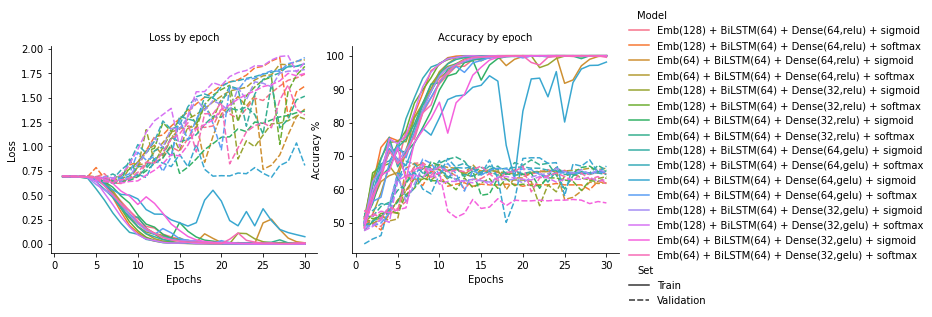

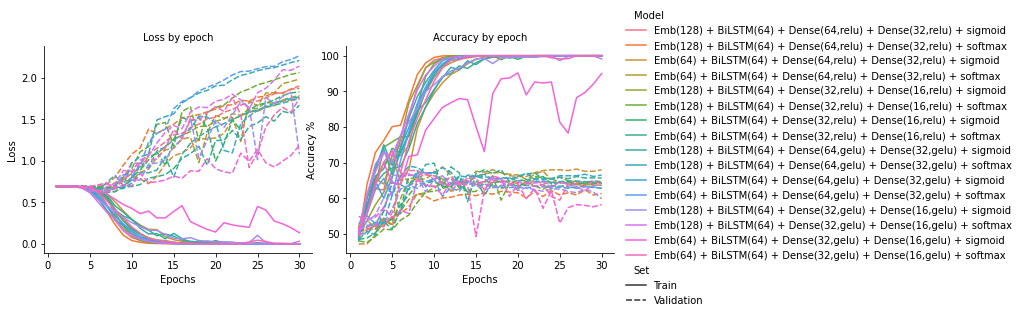

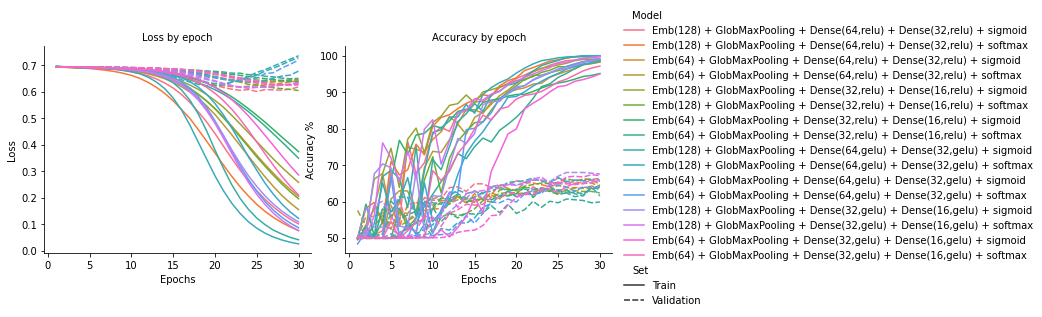

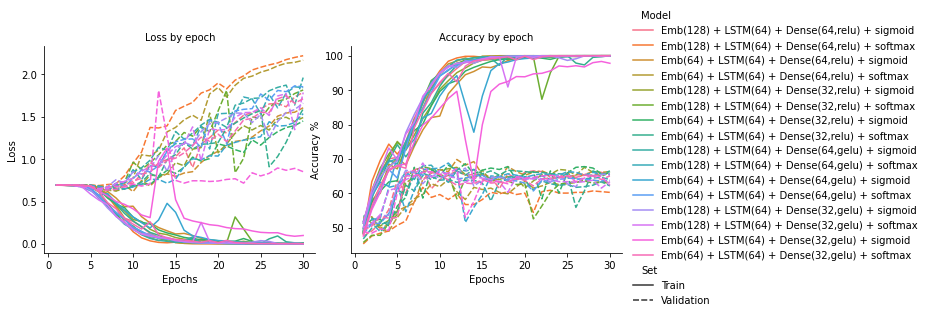

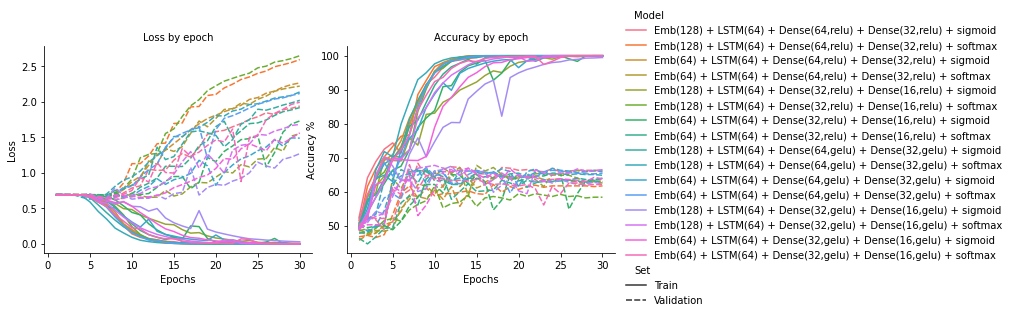

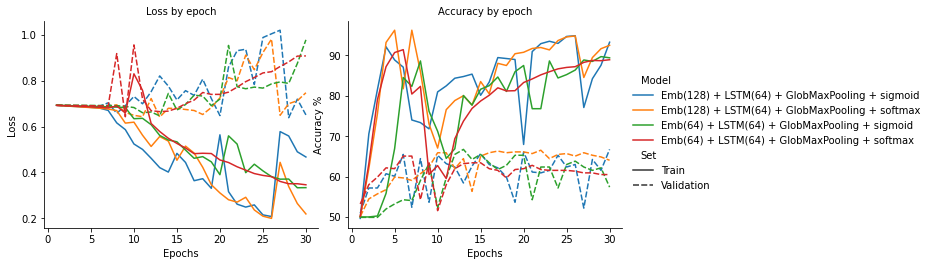

In [10]:
# Plot loss and accuracy curves by type of architecture
for architecture in np.unique(df_for_metrics_chart['Architecture']):

    fig = sns.relplot(
        data = df_for_metrics_chart[df_for_metrics_chart['Architecture'] == architecture], 
        kind = "line",
        x = "Epochs", y = "Values", col = "Metric",
        hue = "Model", style = "Set", 
        height=3.8, aspect = 1.2,
        facet_kws = dict(sharex = True, sharey=False)
    )
    fig.set_titles('{col_name}' + ' by epoch' )
    # fig.set_titles('')
    for ax, title in zip(fig.axes.flat, ['Loss', 'Accuracy %']):
        ax.set_ylabel(title)
    # fig.savefig(path_of_saving_images + 'BERT_individual_model.png')

In [14]:
# Look at the top 10 performing models
table_of_results.sort_values(by=['Test accuracy'], ascending = False)[0:10]

,Model,Train accuracy,Test accuracy,Men accuracy (on test),Women accuracy (on test),Training time (minutes)
74,"Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(...",86.56,71.37,73.33,69.42,5.16
75,"Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(...",84.36,70.54,80.00,61.16,5.13
57,"Emb(128) + LSTM(64) + Dense(64,gelu) + Dense(3...",80.50,69.71,79.17,60.33,3.25
33,"Emb(128) + BiLSTM(64) + Dense(64,relu) + softmax",91.38,69.29,65.83,72.73,5.33
63,"Emb(64) + LSTM(64) + Dense(32,gelu) + Dense(16...",83.77,69.29,65.83,72.73,2.77
77,"Emb(128) + BiLSTM(64) + Dense(32,gelu) + Dense...",85.08,68.88,64.17,73.55,5.18
36,"Emb(128) + BiLSTM(64) + Dense(32,relu) + sigmoid",86.15,68.88,63.33,74.38,5.22
81,Emb(128) + LSTM(64) + GlobMaxPooling + softmax,86.68,68.88,70.00,67.77,2.86
41,"Emb(128) + BiLSTM(64) + Dense(64,gelu) + softmax",85.97,68.46,70.83,66.12,5.18
39,"Emb(64) + BiLSTM(64) + Dense(32,relu) + softmax",86.92,68.46,64.17,72.73,5.16


In [15]:
# Select the best 5
best_models = summarized_table.sort_values(by=['test_accuracy'], ascending = False)[0:5]['model_name']

In [16]:
# Get latex table
with pd.option_context('max_colwidth', 1000):
    print(table_of_results.sort_values(by=['Test accuracy'], ascending = False)[0:5].to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
                                                           Model &  Train accuracy &  Test accuracy &  Men accuracy (on test) &  Women accuracy (on test) &  Training time (minutes) \\
\midrule
Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid &           86.56 &          71.37 &                   73.33 &                     69.42 &                     5.16 \\
Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax &           84.36 &          70.54 &                   80.00 &                     61.16 &                     5.13 \\
 Emb(128) + LSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax &           80.50 &          69.71 &                   79.17 &                     60.33 &                     3.25 \\
                Emb(128) + BiLSTM(64) + Dense(64,relu) + softmax &           91.38 &          69.29 &                   65.83 &                     72.73 &                     5.33 \\
  Emb(64) + LSTM(64) + Dense(32,gelu) 

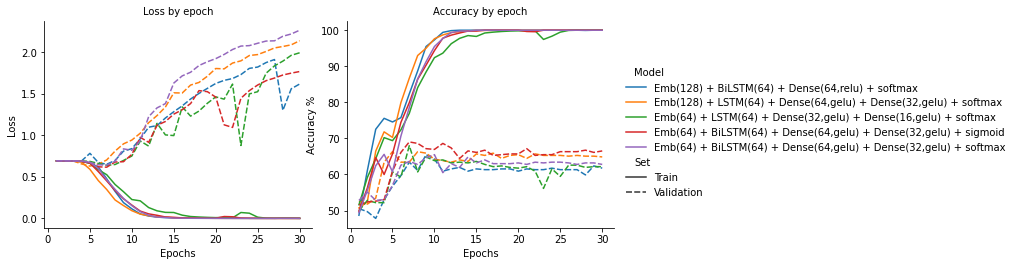

In [49]:
# Plot the best 5
fig = sns.relplot(
    data = df_for_metrics_chart[df_for_metrics_chart['model_name'].isin(best_models)], 
    kind = "line",
    x = "Epochs", y = "Values", col = "Metric",
    hue = "Model", style = "Set", 
    height=3.8, aspect = 1.2,
    facet_kws = dict(sharex = True, sharey=False)
)
fig.set_titles('{col_name}' + ' by epoch' )
for ax, title in zip(fig.axes.flat, ['Loss', 'Accuracy %']):
    ax.set_ylabel(title)
fig.savefig(path_of_saving_images + 'best_deep_model_individual.png')
fig.savefig(path_of_saving_images + 'best_deep_model_individual.pdf')

# Leave-some-movies-out

Now we train again the best 5 performing models. 
This time **leave-one-group-out** cross-validation is used. 
In this case each group is a group of movies.  

In [44]:
for m in best_models:
    model_info = model_combinations[m]
    print('--------------------------------------')
    print('Leave-one-group-out for model:', model_info['model_nice_name'])
    print('--------------------------------------')
    leave_one_group_out_deepmodels(data = cornell_prepro_characters, 
                                   group_variable = 'movieGroup',
                                   text_variable = 'text_chosen_vocab', 
                                   target_variable = 'target',  
                                   model_info = model_info, 
                                   path_to_models = path_to_models, 
                                   epochs = 20)


--------------------------------------
Leave-one-group-out for model: Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid
--------------------------------------
Test Accuracy: 0.6074380278587341
----------------------------
Finished for group: 1
----------------------------
Test Accuracy: 0.6569767594337463
----------------------------
Finished for group: 2
----------------------------
Test Accuracy: 0.6734693646430969
----------------------------
Finished for group: 3
----------------------------
Test Accuracy: 0.5685840845108032
----------------------------
Finished for group: 4
----------------------------
Test Accuracy: 0.6926407217979431
----------------------------
Finished for group: 5
----------------------------
--------------------------------------
Leave-one-group-out for model: Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax
--------------------------------------
Test Accuracy: 0.692148745059967
----------------------------
Finished for group: 

## Results of leave-one-group-out cross-validation

Here we look at the results of the best 3.

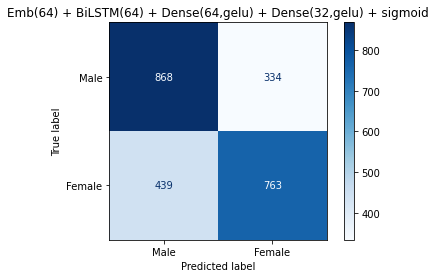

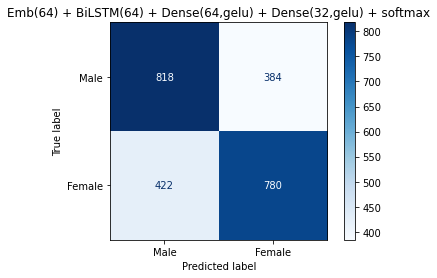

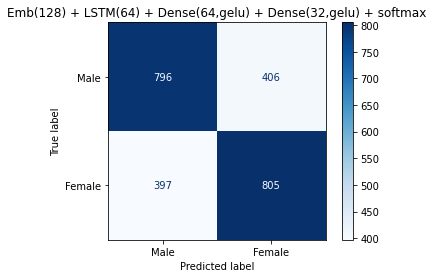

\begin{tabular}{lllllr}
\toprule
                                                           Model & Avg. train accuracy ± std & Avg. test accuracy ± std & Avg. men accuracy ± std (on test) & Avg. women accuracy ± std (on test) &  Training time (minutes) \\
\midrule
Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + sigmoid &               79.6 ± 6.14 &             63.98 ± 4.55 &                      73.09 ± 8.24 &                       54.88 ± 15.53 &                     3.19 \\
Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax &              83.99 ± 3.68 &             67.36 ± 1.31 &                      67.58 ± 4.96 &                        67.13 ± 2.46 &                     3.27 \\
 Emb(128) + LSTM(64) + Dense(64,gelu) + Dense(32,gelu) + softmax &              80.54 ± 2.22 &             65.29 ± 1.88 &                     60.18 ± 11.75 &                        70.41 ± 8.56 &                     2.01 \\
\bottomrule
\end{tabular}



,Model,Avg. train accuracy ± std,Avg. test accuracy ± std,Avg. men accuracy ± std (on test),Avg. women accuracy ± std (on test),Training time (minutes)
0,"Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(...",79.6 ± 6.14,63.98 ± 4.55,73.09 ± 8.24,54.88 ± 15.53,3.19
1,"Emb(64) + BiLSTM(64) + Dense(64,gelu) + Dense(...",83.99 ± 3.68,67.36 ± 1.31,67.58 ± 4.96,67.13 ± 2.46,3.27
2,"Emb(128) + LSTM(64) + Dense(64,gelu) + Dense(3...",80.54 ± 2.22,65.29 ± 1.88,60.18 ± 11.75,70.41 ± 8.56,2.01


In [54]:
table_of_results = {'Model': [], 'Avg. train accuracy \u00B1 std':[], 'Avg. test accuracy \u00B1 std':[], 'Avg. men accuracy \u00B1 std (on test)':[], 'Avg. women accuracy \u00B1 std (on test)':[], 'Training time (minutes)': []}
df_for_metrics_chart = {'Model': [], 'Epochs': [], 'Set': [], 'Metric': [], 'Values': [], 'Group': [], 'Model architecture':[]}

for m in best_models[0:3]: 

    model_info = model_combinations[m]

    # Load results
    results = pickle.load(open(path_to_models + model_info['model_name'] + 'LOGO' + ".pickle", "rb" ))
    
    # Results for table
    results_keys = ['train_accuracy', 'test_accuracy', 'test_accuracy_0', 'test_accuracy_1']
    table_keys = ['Avg. train accuracy \u00B1 std', 'Avg. test accuracy \u00B1 std', 'Avg. men accuracy \u00B1 std (on test)', 'Avg. women accuracy \u00B1 std (on test)']
    for key, table_key in zip(results_keys, table_keys):
        mean_and_std = str(np.round(np.mean(results[key])*100, 2)) + ' \u00B1 ' +  str(np.round(np.std(results[key])*100, 2))
        table_of_results[table_key].append(mean_and_std)
    table_of_results['Model'].append(model_info['model_nice_name'])
    table_of_results['Training time (minutes)'].append(np.mean(results['execution_time']))

    # # Results for plot 
    metrics_history = results['history_metrics']   
    groups = len(metrics_history)
    epochs = len(metrics_history[0]['loss']) 
    model_abreviated = model_info['model_nice_name'].replace('Emb', 'E').replace('LSTM(64)', 'LSTM').replace('Dense', 'D')
    df_for_metrics_chart['Model'].extend([model_abreviated] * 4 * epochs * groups)
    df_for_metrics_chart['Model architecture'].extend([model_info['model_nice_name']] * 4 * epochs * groups)
    df_for_metrics_chart['Epochs'].extend(list(range(1,epochs+1)) * 4 * groups)
    df_for_metrics_chart['Set'].extend(list(['Train'] *  epochs * groups + ['Validation'] * epochs * groups) * 2)
    df_for_metrics_chart['Metric'].extend(['Loss'] * 2 * epochs *groups + ['Accuracy'] * 2 * epochs * groups)
    df_for_metrics_chart['Group'].extend(list(np.repeat(range(1, groups + 1), epochs)) * 4)
    df_for_metrics_chart['Values'].extend(np.concatenate((
                                                        np.array([i['loss'] for i in metrics_history]).flatten(), 
                                                        np.array([i['val_loss'] for i in metrics_history]).flatten(),
                                                        np.array([i['accuracy'] for i in metrics_history]).flatten() * 100,
                                                        np.array([i['val_accuracy'] for i in metrics_history]).flatten() * 100
                                                        )))
    
    # Confusion matrix
    cm = confusion_matrix(y_true = results['ground_truth'], y_pred = results['predictions_on_test'])
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    # confusion_matrices.append(cmdisp)
    cmdisp.plot(cmap = 'Blues')
    plt.title(model_info['model_nice_name'])
    plt.show()
  
# To pandas dataframes
table_of_results = pd.DataFrame(table_of_results).round(2)
df_for_metrics_chart = pd.DataFrame(df_for_metrics_chart)

# # Latex table
with pd.option_context('max_colwidth', 1000):
    print(table_of_results.to_latex(index=False))

# # Show results
table_of_results


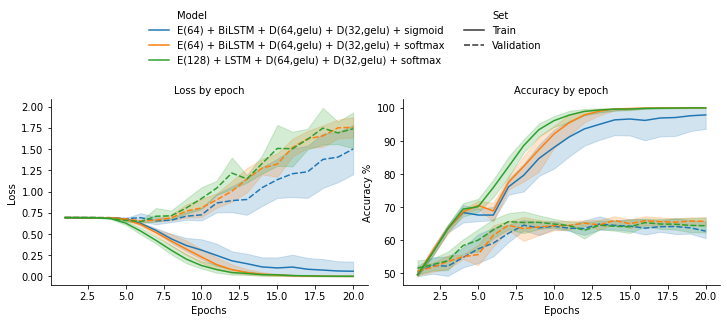

In [57]:
fig = sns.relplot(
    data = df_for_metrics_chart, kind = "line",
    x = "Epochs", y = "Values", col = "Metric",
    hue = "Model", 
    # hue = "Model architecture", 
    style = "Set", 
    height = 3.5, aspect = 1.5,
    facet_kws = dict(sharex = True, sharey=False)
)
fig.set_titles('{col_name}' + ' by epoch' )
# fig.set_titles('')

sns.move_legend(
    fig, "lower center",
    bbox_to_anchor=(0.35, 1),
    ncol=2,
    title=None, frameon=False,
)

for ax, title in zip(fig.axes.flat, ['Loss', 'Accuracy %']):
    ax.set_ylabel(title)
fig.savefig(path_of_saving_images + 'best_deep_model_LOGO.png')
fig.savefig(path_of_saving_images + 'best_deep_model_LOGO.pdf')